# Trabajo Practico - Desarrollo de software para el cálculo de parámetros acústicos ISO 3382 (1er entrega)

## Fecha de entrega

*Ingresar fecha*

## Integrantes

* <Tyler, Cruz>
* <Nombre, Apellido>
* <Nombre, Apellido>

## Aspectos generales del notebook

* Todas las funciones deben contar con su [docstring](https://realpython.com/documenting-python-code/#docstring-types), como figura en la funcion de ejemplo (`ruidoRosa_voss`).
* Todos los gráficos deben tener correctamente etiquetados los ejes.
* Enviar el notebook (.ipynb) completado y con las celdas ejecutas a myommi@untref.edu.ar.
* Todas las señales de audio deben ser grabadas en formato .wav en la misma función que las genera.

## Librerias utilizadas
Agregar todas las librerias utilizadas, algunas a modo de ejemplo:

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf 
import sounddevice as sd

## Función de sintetización de ruido rosa
El ruido rosa o ruido $\frac{1}{\sqrt{f}}$ , dónde $f$ denota frecuencia en Hz, es un ruido con una distribución de frecuencias tal que su densidad espectral de potencia es proporcional a la inversa de la frecuencia. Esto implica que su nivel, por bandas de tercio de octava, es constante. El nivel del ruido rosa por intervalo fijo de frecuencias va decayendo a razón de 3 dB/octava, de forma no lineal aunque las frecuencias se representan en un eje lineal.

Se adjunta a continuación una función que devuelva un ruido rosa sintetizado a partir del algoritmo de Voss y Clarke (pueden encontrar mas informacion en [este enlace](https://www.dsprelated.com/showabstract/3933.php) y en [este notebook](https://github.com/AllenDowney/ThinkDSP/blob/master/code/voss.ipynb)). 

**Consigna:** modificar la función original para que reciba como parametro la duración del ruido en segundos $t$ y como parametro opcional la frecuencia de muestreo $fs$ (Ayuda: la longitud de la señal sera el producto entre ambos). La función debe guardar el archivo de audio .wav de la señal generada y devolver el vector de datos de la señal.

In [9]:
def ruidoRosa_voss(t, ncols, fs=44100):
    """
    Genera ruido rosa utilizando el algoritmo de Voss-McCartney(https://www.dsprelated.com/showabstract/3933.php).
    
    .. Nota:: si 'ruidoRosa.wav' existe, este será sobreescrito
    
    Parametros
    ----------
    t : float
        Valor temporal en segundos, este determina la duración del ruido generado.
    rcols: int
        Determina el número de fuentes a aleatorias a agregar.
    fs: int
        Frecuencia de muestreo en Hz de la señal. Por defecto el valor es 44100 Hz.
    
    returns: NumPy array
        Datos de la señal generada.
    """
    
    nrows = int(float(t)*fs)

    array = np.full((nrows, ncols), np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)

    # El número total de cambios es nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    filled = df.fillna(method='ffill', axis=0)
    total = filled.sum(axis=1)

    # Centrado del array en 0
    total = total - total.mean()

    # Normalizado
    valor_max = max(abs(max(total)), abs(min(total)))
    total = total / valor_max

    # Agregar generación de archivo de audio .wav
    sf.write('ruido_rosa.wav', total, fs)

    return total

Ejemplo
    Generar un `.wav` desde un numpy array de 10 segundos con ruido rosa a una 
    frecuencia de muestreo de 44100 Hz.

In [10]:
ruido_rosa = ruidoRosa_voss(10,16,44100)

Realizar una función para visualizar el dominio temporal de la señal.

In [11]:
def dominio_temporal(t,fs=44100):
    """
    Grafica el dominio temporal del ruido rosa generado.
    
    Parametros
    ----------
    t : float
        Valor temporal en segundos.
    fs: int
        Frecuencia de muestreo en Hz de la señal. Por defecto el valor es 44100 Hz.
    
    returns: Gráfico de la señal (ruido rosa).
    """
    
    #Eje x: tiempo
    eje_x = np.linspace(0,t+1,t*fs)
    plt.xlabel("Tiempo (s)")
    
    #Eje y: amplitud normalizada
    eje_y = ruido_rosa
    plt.ylabel("Amplitud Normalizada")
    
    plt.title("Dominio temporal de la señal")
    plt.plot(eje_x, eje_y, color="hotpink")
    
    return plt.show()

Llamar a la función.

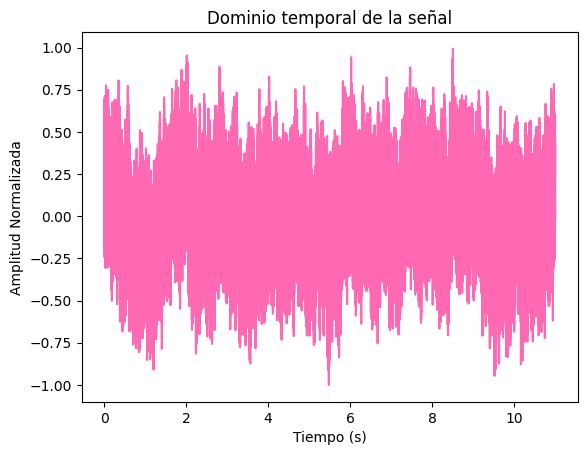

In [12]:
dominio_temporal(10,44100)

Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

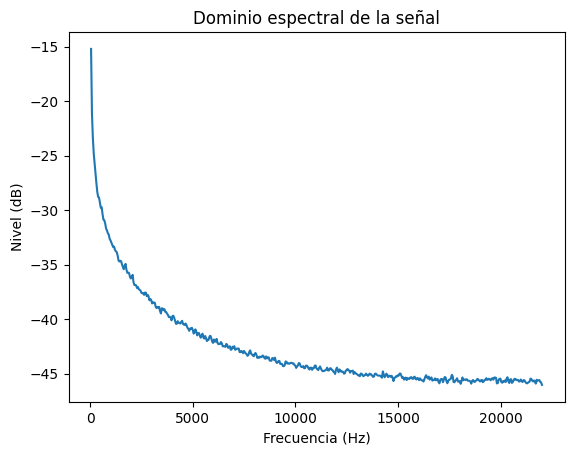

In [40]:
df = pd.read_csv('./pinknoise_spectrum.txt',delimiter='\t')

#Eje x: frecuencia
eje_x = df['Frequency (Hz)']
plt.xlabel('Frecuencia (Hz)')
    
#Eje y: nivel (dB)
eje_y = df['Level (dB)']
plt.ylabel('Nivel (dB)')
    
plt.title('Dominio espectral de la señal')
plt.plot(eje_x, eje_y)
plt.show()

Reproducir resultado.

In [18]:
sd.play(ruido_rosa,44100)
sd.wait()

## Funcion de generación de sine sweep logaritmico + filtro inverso
El sine sweep es el método más indicado para generar el impulso por medio de la convolución (Nikolić, I., and O. H. Bjor, 2003). Dado que métodos tales como: explosión de globo, aplauso, disparo con pistola se salva, paper gun ([Paper Popper](https://en.wikipedia.org/wiki/Paper_popper)), golpe entre maderas, petardos, entre otros, carecen de reproducibilidad. Esto es debido a su nivel sonoro, duración y características espectrales, además de una muy baja relación señal ruido, la cual difícilmente se solucione filtrando o promediando con muchas mediciones. Comencemos por ver cómo generar el sine sweep logarítmico $x(t)$ que posee la siguiente forma:

\begin{equation}
f(x) = \sin[\theta(t)]= \sin[K (e^\frac{t}{L} - 1) ]
\tag{1}
\end{equation}

Donde:

\begin{equation}
K = \frac{T w_{1}}{R}
\end{equation}

\begin{equation}
L = \frac{T}{R}
\end{equation}

y el sweep rate $R$: 

\begin{equation}
R = \ln \left( \frac{w_{2}}{w_{1}} \right)
\tag{2}
\end{equation}

Con $w_{1}$ y $w_{2}$, las frecuencias angulares inferior y superior respectivamente, $T$ es el tiempo de duración del sine sweep en segundos (Meng, Q., 2008). Si estudiamos el espectro de la señal de la ecuación (1), se observa que no es plano, sino que disminuye a razón de -3 dB/octava, como el ruido rosa (Ver fig. 2, sup). De modo que el espectro de $x(-t)$ debe ser ajustado, aumentando en 3 dB/octava, de modo que cuando realizamos el cálculo se restaure la plenitud perfecta de la respuesta de impulso medida $h(t)$ (Farina A., 2000) (Ver fig. 2, inf).

![](../img/image43.png)
<center><b>Fig 2.</b> Espectro del sine sweep. Sine sweep logarítmico  (sup). Filtro invertido (inf).</center>


En el dominio temporal las señales del sine sweep logarítmico y el filtro inverso se comportan de la siguiente manera (Ver fig. 3). 

![](../img/image46.png)
<center><b>Fig 3.</b> Magnitud del sine sweep. Sine sweep logarítmico (sup). Filtro invertido (inf).</center>

Para generar el filtro inverso $k(t)$ del sine sweep logarítmico $x(t)$ se requiere de una modulación $m(t)$ definida por la siguiente expresión:

\begin{equation}
m(t) = \frac{w_{1}}{2\pi w(t)}
\tag{3}
\end{equation}

Obtenida de la frecuencia instantánea (dado que la amplitud cambia en función de la
frecuencia), calculada a partir de la ecuación (1):

\begin{equation}
w(t)=\frac{d[\theta (t)]}{dt}=\frac{K}{L} e^\frac{t}{L}
\tag{4}
\end{equation}
m
entonces, el filtro inverso $k(t)$ queda definido como:

\begin{equation}
k(t)=m(t)x(-t)
\tag{5}
\end{equation}

**Consigna:** realizar una función generadora de un sine sweep y su filtro inverso, a partir de las ecuaciones descriptas anteriormente, y graficar el resultado de ambos filtros, usando la función anteriormente creada. Recordar almacenar los audios. Agregar docstring que indique claramente los parametros de entrada y salida.

In [38]:
# completar

Llamar la función.

In [39]:
# completar

Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

In [43]:
# completar

Reproducir resultados.

In [37]:
# completar

## Función adquisicion y reproducción
**Consigna**: la función tiene que permitir la reproducción y la adquisición de manera simultánea para un tiempo determinado por el usuario. Es importante evaluar y constatar dicha simultaneidad. El módulo debería permitir seleccionar el hardware a utilizar. Algunos articulos de interes para el desarrollo:
* [Clase de audio](../../clases/clase_6/600_audio.ipynb)
* [Sound Device - Simultaneous Playback and Recording](https://python-sounddevice.readthedocs.io/en/0.4.1/usage.html#simultaneous-playback-and-recording)
* [Playing and Recording Sound in Python](https://realpython.com/playing-and-recording-sound-python/)
* [Audio in Python](https://wiki.python.org/moin/Audio/)
* [https://github.com/spatialaudio/python-sounddevice/issues/148](https://github.com/spatialaudio/python-sounddevice/issues/148)

In [ ]:
# Completar

Llamar la función.

In [ ]:
# completar

¿Cómo se podría medir la latencia de la función?

In [ ]:
# Completar